In [162]:
import pandas as pd
from etl_functions import parse_lists
import matplotlib.pyplot as plt

# EDA For the steam_games dataset

In [148]:
df_games = pd.read_csv('CleanDatasets/steam_games.csv', converters={'genres':parse_lists,'tags':parse_lists})

In [149]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32132 entries, 0 to 32131
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        32132 non-null  object 
 1   title         32132 non-null  object 
 2   url           32132 non-null  object 
 3   release_date  31860 non-null  object 
 4   tags          32132 non-null  object 
 5   price         32132 non-null  float64
 6   id            32132 non-null  int64  
 7   developer     31554 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [184]:
price_by_labels = df_games.explode('labels').groupby('labels')['price']
df_prices_info = pd.DataFrame({'avg_prices': price_by_labels.median(), 'total_games':price_by_labels.count()})

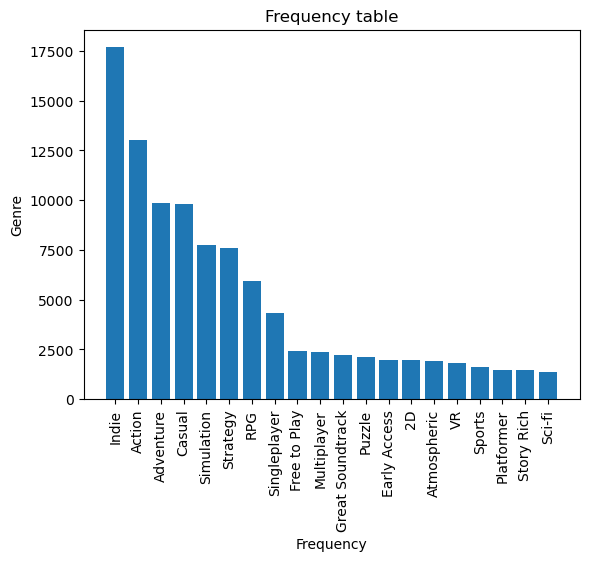

In [185]:
plt.bar(df_prices_info.sort_values(by='total_games', ascending=False).iloc[:20].index, df_prices_info['total_games'].sort_values(ascending=False).iloc[:20])
plt.ylabel('Genre')
plt.xlabel('Frequency')
plt.xticks(rotation=90)
plt.title('Frequency table')
plt.show()

In [150]:
from build_datasets import combine_columns
# Create a new label merging the columns tags and genres
df_games['labels'] = df_games.apply(combine_columns, axis=1)
df_games['labels'] = df_games['labels'].fillna("[]").apply(lambda x: list(set(x)))
# Get the labels that represent better our games and get rid of the ones that introduce noise
labels_proportion = df_games['labels'].explode().value_counts() / len(df_games['labels'])

In [151]:
labels_proportion[labels_proportion > 0.01]

labels
Indie            0.550137
Action           0.405608
Adventure        0.306641
Casual           0.304618
Simulation       0.241691
                   ...   
Tower Defense    0.010737
Action RPG       0.010488
Management       0.010208
Music            0.010115
Dark             0.010083
Name: count, Length: 85, dtype: float64

In [152]:
# Keep the categories with a percentage of appearence greater than 1%
significant_labels = labels_proportion[labels_proportion > 0.01].index.tolist()

In [153]:
# Create a new column in our dataset with the most significant labels
new_labels = df_games['labels'].apply(lambda x: [i for i in x if i in (significant_labels)])

df_games['significant_labels'] = new_labels

In [154]:
df_games.price.describe()

count    32132.000000
mean         9.145289
std         22.095066
min          0.000000
25%          1.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

We can notice that the price is skewed to the right, something expected

In [15]:
df_games.price.skew()

20.30175172821163

In [22]:
df_exploded_by_genres = df_games.explode('genres')
df_prices_by_genre = df_exploded_by_genres.groupby('genres')['price'].median()
df_total_games_per_genre = df_exploded_by_genres.groupby('genres')['price'].count()
df_prices_info = pd.DataFrame({'avg_prices': df_prices_by_genre, 'total_games':df_total_games_per_genre})

In [23]:
# Information that could be valuable for a regression model
df_prices_info

,avg_prices,total_games
genres,,
Accounting,22.490,10
Action,4.990,12235
Adventure,4.990,8789
Animation & Modeling,19.990,231
Audio Production,17.990,109
Casual,3.990,9100
Design & Illustration,12.990,515
Early Access,8.990,1818
Education,14.990,178


In [206]:
df_games['developer'].value_counts().iloc[:10]

developer
Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Lionsgate                      175
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Stainless Games                 96
Name: count, dtype: int64

# EDA for the user_reviews dataset

In [110]:
df_r = pd.read_csv('CleanDatasets/users_sentiment.csv')
df_aux = pd.read_parquet('CleanDatasets/collaborative_filtering.parquet')

In [115]:
df_r = df_r.merge(df_aux[['user_id', 'item_id', 'title']], how='left', on=['user_id', 'item_id'])

In [120]:
df_r = df_r[['user_id','posted', 'item_id', 'title', 'recommend', 'sentiment_analysis']]

In [121]:
df_r.head()

,user_id,posted,item_id,title,recommend,sentiment_analysis
0,76561197970982479,2011-11-05,1250,Killing Floor,True,2
1,76561197970982479,2011-07-15,22200,Zeno Clash,True,2
2,76561197970982479,2011-04-21,43110,Metro 2033,True,2
3,js41637,2014-06-24,251610,NaN,True,2
4,js41637,2013-09-08,227300,Euro Truck Simulator 2,True,2


In [122]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             58431 non-null  object
 1   posted              58431 non-null  object
 2   item_id             58431 non-null  int64 
 3   title               56297 non-null  object
 4   recommend           58431 non-null  bool  
 5   sentiment_analysis  58431 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 2.3+ MB


In [124]:
# Distribution of the category recommend
df_r['recommend'].value_counts()

recommend
True     51692
False     6739
Name: count, dtype: int64

In [123]:
# Reviews sentiment analysis scores categorized by sentiment
df_r['sentiment_analysis'].value_counts()

sentiment_analysis
2    35390
0    11791
1    11250
Name: count, dtype: int64

In [128]:
# 10 most recommended games
df_r.groupby(['title', 'recommend']).size().sort_values(ascending=False)[:10]

title                             recommend
Team Fortress 2                   True         3571
Counter-Strike: Global Offensive  True         3429
Garry's Mod                       True         1657
Dota 2                            True         1441
Unturned                          True          943
PAYDAY 2                          True          892
Left 4 Dead 2                     True          722
Terraria                          True          711
Rust                              True          695
The Elder Scrolls V: Skyrim       True          669
dtype: int64

In [133]:
# Games with the higher amount of positive reviews
df_r[df_r['sentiment_analysis'] == 2].groupby(['title', 'sentiment_analysis']).size().sort_values(ascending=False)[:10]

title                             sentiment_analysis
Team Fortress 2                   2                     2561
Counter-Strike: Global Offensive  2                     2090
Garry's Mod                       2                     1169
Dota 2                            2                      861
Unturned                          2                      629
PAYDAY 2                          2                      612
Terraria                          2                      542
The Elder Scrolls V: Skyrim       2                      476
Left 4 Dead 2                     2                      473
Rust                              2                      430
dtype: int64

In [132]:
# Games with the higher amount of negative reviews
df_r[df_r['sentiment_analysis'] == 0].groupby(['title', 'sentiment_analysis']).size().sort_values(ascending=False)[:10]

title                             sentiment_analysis
Counter-Strike: Global Offensive  0                     705
Team Fortress 2                   0                     396
Dota 2                            0                     277
DayZ                              0                     277
PAYDAY 2                          0                     254
Rust                              0                     219
Garry's Mod                       0                     206
Unturned                          0                     180
The Elder Scrolls V: Skyrim       0                     109
No Man's Sky                      0                     102
dtype: int64

In [160]:
frequencys = df_r.groupby(['recommend', 'sentiment_analysis']).size().unstack()

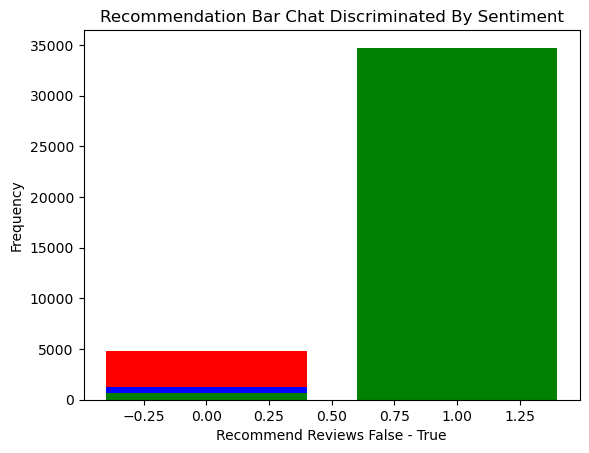

In [163]:
colors = {
    0:'red',
    1:'blue',
    2:'green'
}

for category in frequencys.columns:
    plt.bar(frequencys.index, frequencys[category], label=category, color=colors[category])
plt.xlabel('Recommend Reviews False - True')
plt.ylabel('Frequency')
plt.title('Recommendation Bar Chat Discriminated By Sentiment')
plt.show() 

In [201]:
from wordcloud import WordCloud
reviews = pd.read_csv('CleanDatasets/users_reviews.csv')['review']

In [202]:
reviews = ' '.join(reviews)
wordcloud = WordCloud(width=800, height=500, background_color='white', max_words=200).generate(reviews)

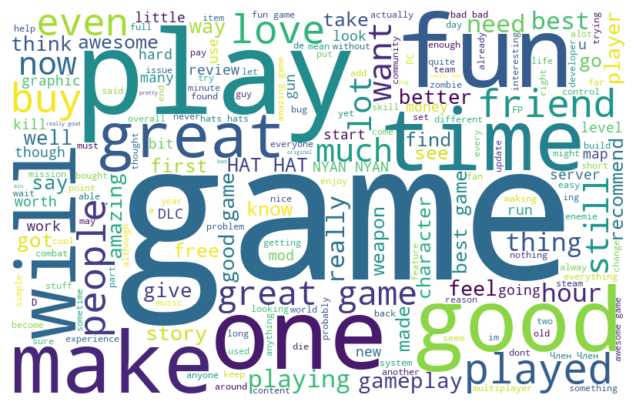

In [203]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# The words HAT HAT and NYAN NYAN seems to be spam 

# EDA for the user_items dataset

In [207]:
df_i = pd.read_csv('CleanDatasets/users_items.csv')

In [208]:
df_i.head()

,id,item_name,playtime_forever,user_id
0,10,Counter-Strike,6,76561197970982479
1,20,Team Fortress Classic,0,76561197970982479
2,30,Day of Defeat,7,76561197970982479
3,40,Deathmatch Classic,0,76561197970982479
4,50,Half-Life: Opposing Force,0,76561197970982479


In [211]:
# Top 10 games with the most hours played
df_i.groupby('item_name')['playtime_forever'].sum().sort_values(ascending=False)[:10]

item_name
Counter-Strike: Global Offensive    785184267
Garry's Mod                         448366616
Terraria                            154974541
The Elder Scrolls V: Skyrim         136678626
Warframe                            124027703
Counter-Strike: Source              112612047
Left 4 Dead 2                       102189423
PAYDAY 2                             99763914
Sid Meier's Civilization V           82380684
Rust                                 81120416
Name: playtime_forever, dtype: int64

In [215]:
# Top 10 users with the most games owned
df_i.groupby('user_id').size().sort_values(ascending=False)[:10]

user_id
phrostb              7762
thugnificent         6700
chidvd               6410
piepai               6132
mayshowganmore       5027
DeEggMeister         4576
76561198070585472    4456
Steamified           4432
rawrvixen            4212
djnemonic            3876
dtype: int64

In [218]:
# Top 10 users with the most games played for more than 50 hours
df_i[df_i['playtime_forever'] > 50].groupby('user_id').size().sort_values(ascending=False)[:10]

user_id
phrostb              2746
thugnificent         2719
chidvd               2670
mayshowganmore       2303
Steamified           2269
djnemonic            2189
piepai               1891
rawrvixen            1815
Outbackalien         1777
76561198070585472    1592
dtype: int64

In [221]:
# We can use this dataset to make more accurate recommendations in our models
# based on the games that the user has more than 50 hours played
df_i[df_i['playtime_forever'] > 50]

,id,item_name,playtime_forever,user_id
8,300,Day of Defeat: Source,4733,76561197970982479
9,240,Counter-Strike: Source,1853,76561197970982479
10,3830,Psychonauts,333,76561197970982479
11,2630,Call of Duty 2,75,76561197970982479
12,3900,Sid Meier's Civilization IV,338,76561197970982479
...,...,...,...,...
5152677,442080,Riders of Icarus,153,76561198320038728
5152993,273350,Evolve Stage 2,103,76561198320136420
5153000,730,Counter-Strike: Global Offensive,4557,ArkPlays7
5153001,346110,ARK: Survival Evolved,623,ArkPlays7
